# JoJoGAN: One Shot Face Stylization

First, run the cell below to install all the requirements to run JoJoGAN

In [ ]:
!pip install gdown scikit-learn==0.22 scipy lpips dlib opencv-python-headless wandb tensorflow
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!unzip ninja-linux.zip -d /usr/local/bin/
!update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force



In [ ]:
#imports
import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import lpips
import wandb
from model import *
from e4e_projection import projection as e4e_projection
from copy import deepcopy


os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [ ]:
!gdown https://drive.google.com/uc?id=1s-AS7WRUbL3MzEALxM8y4_XO3n3panxH
!tar -xf pretrained_models.tar.gz
!mv pretrained_models/stylegan2-ffhq-config-f.pt ~/../notebooks
!gdown https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P

In [ ]:

device = 'cuda' #@param ['cuda', 'cpu']

latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('../stylegan2-ffhq-config-f.pt')
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)

transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
%matplotlib inline
filename = 'iu.jpeg' #@param {type:"string"}
filepath = f'test_input/{filename}'

# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')


AssertionError: Face not detected, try another face image

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


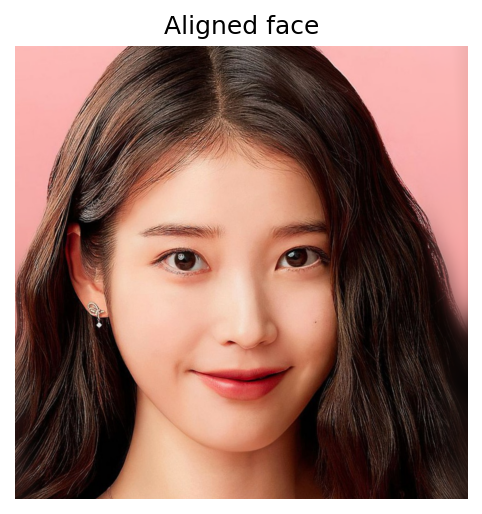

In [ ]:
plt.rcParams['figure.dpi'] = 150

#@title Choose input face
#@markdown Add your own image to the test_input directory and put the name here
filename = 'iu.jpeg' #@param {type:"string"}
filepath = f'test_input/{filename}'

# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')
plt.show()

# Use pretrained styles

In [ ]:
!gdown https://drive.google.com/uc?id=15V9s09sgaw-zhKp116VHigf5FowAy43f

# To download more pretrained style models, use the gdown script above with the corresponding id's (the values)
# drive_ids = {
#     "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
#     "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
#     "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
#     "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
#     "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
#     "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
#     "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
#     "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
#     "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
#     "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
#     "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
#     "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
#     "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
#     "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
#     "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
#     "supergirl.pt": "1L0y9IYgzLNzB-33xTpXpecsKU-t9DpVC",
#     "supergirl_preserve_color.pt": "1VmKGuvThWHym7YuayXxjv0fSn32lfDpE",
#     "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
# }

In [ ]:
plt.rcParams['figure.dpi'] = 150
pretrained = 'arcane_multi' #@param ['art', 'arcane_multi', 'supergirl', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']
#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = False #@param{type:"boolean"}

ckpt = torch.load('arcane_multi.pt')
generator.load_state_dict(ckpt["g"], strict=False)

#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

# display reference images
if pretrained == 'arcane_multi':
    style_path = f'style_images_aligned/arcane_jinx.png'
else:   
    style_path = f'style_images_aligned/{pretrained}.png'
style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
face = transform(aligned_face).unsqueeze(0).to(device)

my_output = torch.cat([style_image, face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')
plt.show()

output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')
plt.show()

# Train with your own style images

In [ ]:

!python Run_Stylizer.py

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


/opt/conda/lib/python3.8/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Loading model from: /opt/conda/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth



  0%|                                                   | 0/200 [00:00<?, ?it/s]


  0%|▏                                          | 1/200 [00:09<32:20,  9.75s/it]


  1%|▍                                          | 2/200 [00:10<14:22,  4.35s/it]


  2%|▋                                          | 3/200 [00:10<08:38,  2.63s/it]


  2%|▊                                          | 4/200 [00:11<05:57,  1.82s/it]


  2%|█                                          | 5/200 [00:12<04:28,  1.38s/it]


  3%|█▎                                         | 6/200 [00:12<03:34,  1.11s/it]


  4%|█▌                                         | 7/200 [00:13<03:00,  1.07it/s]


  4%|█▋                                         | 8/200 [00:13<02:38,  1.21it/s]


  4%|█▉                                         | 9/200 [00:14<02:22,  1.34it/s]


  5%|██                                        | 10/200 [00:15<02:12,  1.43it/s]


  6%|██▎                                       | 11/200 [00:15<02:05,  1.51it/s]


  6%|██▌                                       | 12/200 [00:16<02:00,  1.56it/s]


  6%|██▋                                       | 13/200 [00:16<01:56,  1.61it/s]


  7%|██▉                                       | 14/200 [00:17<01:53,  1.64it/s]


  8%|███▏                                      | 15/200 [00:17<01:51,  1.66it/s]


  8%|███▎                                      | 16/200 [00:18<01:49,  1.67it/s]


  8%|███▌                                      | 17/200 [00:19<01:48,  1.68it/s]


  9%|███▊                                      | 18/200 [00:19<01:47,  1.69it/s]


 10%|███▉                                      | 19/200 [00:20<01:46,  1.69it/s]


 10%|████▏                                     | 20/200 [00:20<01:45,  1.70it/s]


 10%|████▍                                     | 21/200 [00:21<01:45,  1.70it/s]


 11%|████▌                                     | 22/200 [00:22<01:44,  1.71it/s]


 12%|████▊                                     | 23/200 [00:22<01:43,  1.71it/s]


 12%|█████                                     | 24/200 [00:23<01:43,  1.71it/s]


 12%|█████▎                                    | 25/200 [00:23<01:42,  1.71it/s]


 13%|█████▍                                    | 26/200 [00:24<01:41,  1.71it/s]


 14%|█████▋                                    | 27/200 [00:24<01:41,  1.71it/s]


 14%|█████▉                                    | 28/200 [00:25<01:40,  1.71it/s]


 14%|██████                                    | 29/200 [00:26<01:39,  1.71it/s]


 15%|██████▎                                   | 30/200 [00:26<01:39,  1.71it/s]


 16%|██████▌                                   | 31/200 [00:27<01:38,  1.71it/s]


 16%|██████▋                                   | 32/200 [00:27<01:38,  1.71it/s]


 16%|██████▉                                   | 33/200 [00:28<01:37,  1.71it/s]


 17%|███████▏                                  | 34/200 [00:29<01:37,  1.71it/s]


 18%|███████▎                                  | 35/200 [00:29<01:36,  1.71it/s]


 18%|███████▌                                  | 36/200 [00:30<01:35,  1.71it/s]


 18%|███████▊                                  | 37/200 [00:30<01:35,  1.71it/s]


 19%|███████▉                                  | 38/200 [00:31<01:34,  1.71it/s]


 20%|████████▏                                 | 39/200 [00:31<01:34,  1.71it/s]


 20%|████████▍                                 | 40/200 [00:32<01:33,  1.71it/s]


 20%|████████▌                                 | 41/200 [00:33<01:33,  1.70it/s]


 21%|████████▊                                 | 42/200 [00:33<01:32,  1.71it/s]


 22%|█████████                                 | 43/200 [00:34<01:32,  1.71it/s]


 22%|█████████▏                                | 44/200 [00:34<01:31,  1.71it/s]


 22%|█████████▍                                | 45/200 [00:35<01:30,  1.70it/s]


 23%|█████████▋                                | 46/200 [00:36<01:30,  1.70it/s]


 24%|█████████▊                                | 47/200 [00:36<01:29,  1.70it/s]


 24%|██████████                                | 48/200 [00:37<01:29,  1.70it/s]


 24%|██████████▎                               | 49/200 [00:37<01:28,  1.70it/s]


 25%|██████████▌                               | 50/200 [00:38<01:28,  1.70it/s]


 26%|██████████▋                               | 51/200 [00:39<01:27,  1.70it/s]


 26%|██████████▉                               | 52/200 [00:39<01:27,  1.70it/s]


 26%|███████████▏                              | 53/200 [00:40<01:26,  1.70it/s]


 27%|███████████▎                              | 54/200 [00:40<01:25,  1.70it/s]


 28%|███████████▌                              | 55/200 [00:41<01:25,  1.70it/s]


 28%|███████████▊                              | 56/200 [00:41<01:24,  1.70it/s]


 28%|███████████▉                              | 57/200 [00:42<01:24,  1.70it/s]


 29%|████████████▏                             | 58/200 [00:43<01:23,  1.70it/s]


 30%|████████████▍                             | 59/200 [00:43<01:22,  1.70it/s]


 30%|████████████▌                             | 60/200 [00:44<01:22,  1.70it/s]


 30%|████████████▊                             | 61/200 [00:44<01:21,  1.70it/s]


 31%|█████████████                             | 62/200 [00:45<01:21,  1.70it/s]


 32%|█████████████▏                            | 63/200 [00:46<01:20,  1.70it/s]


 32%|█████████████▍                            | 64/200 [00:46<01:20,  1.70it/s]


 32%|█████████████▋                            | 65/200 [00:47<01:19,  1.70it/s]


 33%|█████████████▊                            | 66/200 [00:47<01:19,  1.70it/s]


 34%|██████████████                            | 67/200 [00:48<01:18,  1.70it/s]


 34%|██████████████▎                           | 68/200 [00:49<01:17,  1.70it/s]


 34%|██████████████▍                           | 69/200 [00:49<01:17,  1.70it/s]


 35%|██████████████▋                           | 70/200 [00:50<01:16,  1.70it/s]


 36%|██████████████▉                           | 71/200 [00:50<01:15,  1.70it/s]


 36%|███████████████                           | 72/200 [00:51<01:15,  1.70it/s]


 36%|███████████████▎                          | 73/200 [00:51<01:14,  1.70it/s]


 37%|███████████████▌                          | 74/200 [00:52<01:14,  1.70it/s]


 38%|███████████████▊                          | 75/200 [00:53<01:13,  1.70it/s]


 38%|███████████████▉                          | 76/200 [00:53<01:12,  1.70it/s]


 38%|████████████████▏                         | 77/200 [00:54<01:12,  1.70it/s]


 39%|████████████████▍                         | 78/200 [00:54<01:11,  1.70it/s]


 40%|████████████████▌                         | 79/200 [00:55<01:11,  1.70it/s]


 40%|████████████████▊                         | 80/200 [00:56<01:10,  1.70it/s]


 40%|█████████████████                         | 81/200 [00:56<01:10,  1.70it/s]


 41%|█████████████████▏                        | 82/200 [00:57<01:09,  1.70it/s]


 42%|█████████████████▍                        | 83/200 [00:57<01:08,  1.70it/s]


 42%|█████████████████▋                        | 84/200 [00:58<01:08,  1.70it/s]


 42%|█████████████████▊                        | 85/200 [00:59<01:07,  1.70it/s]


 43%|██████████████████                        | 86/200 [00:59<01:07,  1.70it/s]


 44%|██████████████████▎                       | 87/200 [01:00<01:06,  1.70it/s]


 44%|██████████████████▍                       | 88/200 [01:00<01:05,  1.70it/s]


 44%|██████████████████▋                       | 89/200 [01:01<01:05,  1.70it/s]


 45%|██████████████████▉                       | 90/200 [01:01<01:04,  1.70it/s]


 46%|███████████████████                       | 91/200 [01:02<01:04,  1.70it/s]


 46%|███████████████████▎                      | 92/200 [01:03<01:03,  1.70it/s]


 46%|███████████████████▌                      | 93/200 [01:03<01:02,  1.70it/s]


 47%|███████████████████▋                      | 94/200 [01:04<01:02,  1.70it/s]


 48%|███████████████████▉                      | 95/200 [01:04<01:01,  1.70it/s]


 48%|████████████████████▏                     | 96/200 [01:05<01:01,  1.70it/s]


 48%|████████████████████▎                     | 97/200 [01:06<01:00,  1.70it/s]


 49%|████████████████████▌                     | 98/200 [01:06<01:00,  1.70it/s]


 50%|████████████████████▊                     | 99/200 [01:07<00:59,  1.70it/s]


 50%|████████████████████▌                    | 100/200 [01:07<00:58,  1.70it/s]


 50%|████████████████████▋                    | 101/200 [01:08<00:58,  1.70it/s]


 51%|████████████████████▉                    | 102/200 [01:09<00:57,  1.70it/s]


 52%|█████████████████████                    | 103/200 [01:09<00:57,  1.70it/s]


 52%|█████████████████████▎                   | 104/200 [01:10<00:56,  1.70it/s]


 52%|█████████████████████▌                   | 105/200 [01:10<00:56,  1.69it/s]


 53%|█████████████████████▋                   | 106/200 [01:11<00:55,  1.69it/s]


 54%|█████████████████████▉                   | 107/200 [01:11<00:54,  1.69it/s]


 54%|██████████████████████▏                  | 108/200 [01:12<00:54,  1.69it/s]


 55%|██████████████████████▎                  | 109/200 [01:13<00:53,  1.69it/s]


 55%|██████████████████████▌                  | 110/200 [01:13<00:53,  1.69it/s]


 56%|██████████████████████▊                  | 111/200 [01:14<00:52,  1.69it/s]


 56%|██████████████████████▉                  | 112/200 [01:14<00:51,  1.69it/s]


 56%|███████████████████████▏                 | 113/200 [01:15<00:51,  1.69it/s]


 57%|███████████████████████▎                 | 114/200 [01:16<00:50,  1.70it/s]


 57%|███████████████████████▌                 | 115/200 [01:16<00:50,  1.69it/s]


 58%|███████████████████████▊                 | 116/200 [01:17<00:49,  1.69it/s]


 58%|███████████████████████▉                 | 117/200 [01:17<00:48,  1.70it/s]


 59%|████████████████████████▏                | 118/200 [01:18<00:48,  1.70it/s]


 60%|████████████████████████▍                | 119/200 [01:19<00:47,  1.69it/s]


 60%|████████████████████████▌                | 120/200 [01:19<00:47,  1.69it/s]


 60%|████████████████████████▊                | 121/200 [01:20<00:46,  1.69it/s]


 61%|█████████████████████████                | 122/200 [01:20<00:46,  1.69it/s]


 62%|█████████████████████████▏               | 123/200 [01:21<00:45,  1.69it/s]


 62%|█████████████████████████▍               | 124/200 [01:22<00:44,  1.70it/s]


 62%|█████████████████████████▋               | 125/200 [01:22<00:44,  1.69it/s]


 63%|█████████████████████████▊               | 126/200 [01:23<00:43,  1.69it/s]


 64%|██████████████████████████               | 127/200 [01:23<00:43,  1.69it/s]


 64%|██████████████████████████▏              | 128/200 [01:24<00:42,  1.70it/s]


 64%|██████████████████████████▍              | 129/200 [01:24<00:41,  1.69it/s]


 65%|██████████████████████████▋              | 130/200 [01:25<00:41,  1.70it/s]


 66%|██████████████████████████▊              | 131/200 [01:26<00:40,  1.69it/s]


 66%|███████████████████████████              | 132/200 [01:26<00:40,  1.69it/s]


 66%|███████████████████████████▎             | 133/200 [01:27<00:39,  1.69it/s]


 67%|███████████████████████████▍             | 134/200 [01:27<00:38,  1.70it/s]


 68%|███████████████████████████▋             | 135/200 [01:28<00:38,  1.70it/s]


 68%|███████████████████████████▉             | 136/200 [01:29<00:37,  1.70it/s]


 68%|████████████████████████████             | 137/200 [01:29<00:37,  1.70it/s]


 69%|████████████████████████████▎            | 138/200 [01:30<00:36,  1.70it/s]


 70%|████████████████████████████▍            | 139/200 [01:30<00:35,  1.70it/s]


 70%|████████████████████████████▋            | 140/200 [01:31<00:35,  1.70it/s]


 70%|████████████████████████████▉            | 141/200 [01:32<00:34,  1.70it/s]


 71%|█████████████████████████████            | 142/200 [01:32<00:34,  1.69it/s]


 72%|█████████████████████████████▎           | 143/200 [01:33<00:33,  1.70it/s]


 72%|█████████████████████████████▌           | 144/200 [01:33<00:33,  1.69it/s]


 72%|█████████████████████████████▋           | 145/200 [01:34<00:32,  1.70it/s]


 73%|█████████████████████████████▉           | 146/200 [01:34<00:31,  1.70it/s]


 74%|██████████████████████████████▏          | 147/200 [01:35<00:31,  1.70it/s]


 74%|██████████████████████████████▎          | 148/200 [01:36<00:30,  1.70it/s]


 74%|██████████████████████████████▌          | 149/200 [01:36<00:30,  1.70it/s]


 75%|██████████████████████████████▊          | 150/200 [01:37<00:29,  1.70it/s]


 76%|██████████████████████████████▉          | 151/200 [01:37<00:28,  1.70it/s]


 76%|███████████████████████████████▏         | 152/200 [01:38<00:28,  1.70it/s]


 76%|███████████████████████████████▎         | 153/200 [01:39<00:27,  1.70it/s]


 77%|███████████████████████████████▌         | 154/200 [01:39<00:27,  1.70it/s]


 78%|███████████████████████████████▊         | 155/200 [01:40<00:26,  1.70it/s]


 78%|███████████████████████████████▉         | 156/200 [01:40<00:25,  1.70it/s]


 78%|████████████████████████████████▏        | 157/200 [01:41<00:25,  1.69it/s]


 79%|████████████████████████████████▍        | 158/200 [01:42<00:24,  1.69it/s]


 80%|████████████████████████████████▌        | 159/200 [01:42<00:24,  1.69it/s]


 80%|████████████████████████████████▊        | 160/200 [01:43<00:23,  1.69it/s]


 80%|█████████████████████████████████        | 161/200 [01:43<00:22,  1.70it/s]


 81%|█████████████████████████████████▏       | 162/200 [01:44<00:22,  1.70it/s]


 82%|█████████████████████████████████▍       | 163/200 [01:45<00:21,  1.70it/s]


 82%|█████████████████████████████████▌       | 164/200 [01:45<00:21,  1.70it/s]


 82%|█████████████████████████████████▊       | 165/200 [01:46<00:20,  1.70it/s]


 83%|██████████████████████████████████       | 166/200 [01:46<00:20,  1.70it/s]


 84%|██████████████████████████████████▏      | 167/200 [01:47<00:19,  1.70it/s]


 84%|██████████████████████████████████▍      | 168/200 [01:47<00:18,  1.69it/s]


 84%|██████████████████████████████████▋      | 169/200 [01:48<00:18,  1.70it/s]


 85%|██████████████████████████████████▊      | 170/200 [01:49<00:17,  1.69it/s]


 86%|███████████████████████████████████      | 171/200 [01:49<00:17,  1.69it/s]


 86%|███████████████████████████████████▎     | 172/200 [01:50<00:16,  1.69it/s]


 86%|███████████████████████████████████▍     | 173/200 [01:50<00:15,  1.69it/s]


 87%|███████████████████████████████████▋     | 174/200 [01:51<00:15,  1.70it/s]


 88%|███████████████████████████████████▉     | 175/200 [01:52<00:14,  1.70it/s]


 88%|████████████████████████████████████     | 176/200 [01:52<00:14,  1.70it/s]


 88%|████████████████████████████████████▎    | 177/200 [01:53<00:13,  1.70it/s]


 89%|████████████████████████████████████▍    | 178/200 [01:53<00:12,  1.70it/s]


 90%|████████████████████████████████████▋    | 179/200 [01:54<00:12,  1.70it/s]


 90%|████████████████████████████████████▉    | 180/200 [01:55<00:11,  1.70it/s]


 90%|█████████████████████████████████████    | 181/200 [01:55<00:11,  1.69it/s]


 91%|█████████████████████████████████████▎   | 182/200 [01:56<00:10,  1.69it/s]


 92%|█████████████████████████████████████▌   | 183/200 [01:56<00:10,  1.69it/s]


 92%|█████████████████████████████████████▋   | 184/200 [01:57<00:09,  1.70it/s]


 92%|█████████████████████████████████████▉   | 185/200 [01:57<00:08,  1.70it/s]


 93%|██████████████████████████████████████▏  | 186/200 [01:58<00:08,  1.70it/s]


 94%|██████████████████████████████████████▎  | 187/200 [01:59<00:07,  1.70it/s]


 94%|██████████████████████████████████████▌  | 188/200 [01:59<00:07,  1.70it/s]


 94%|██████████████████████████████████████▋  | 189/200 [02:00<00:06,  1.70it/s]


 95%|██████████████████████████████████████▉  | 190/200 [02:00<00:05,  1.70it/s]


 96%|███████████████████████████████████████▏ | 191/200 [02:01<00:05,  1.70it/s]


 96%|███████████████████████████████████████▎ | 192/200 [02:02<00:04,  1.70it/s]


 96%|███████████████████████████████████████▌ | 193/200 [02:02<00:04,  1.70it/s]


 97%|███████████████████████████████████████▊ | 194/200 [02:03<00:03,  1.70it/s]


 98%|███████████████████████████████████████▉ | 195/200 [02:03<00:02,  1.69it/s]


 98%|████████████████████████████████████████▏| 196/200 [02:04<00:02,  1.70it/s]


 98%|████████████████████████████████████████▍| 197/200 [02:05<00:01,  1.69it/s]


 99%|████████████████████████████████████████▌| 198/200 [02:05<00:01,  1.70it/s]


100%|████████████████████████████████████████▊| 199/200 [02:06<00:00,  1.69it/s]


100%|█████████████████████████████████████████| 200/200 [02:06<00:00,  1.58it/s]


In [ ]:
#@title Finetune StyleGAN
#@markdown alpha controls the strength of the style
alpha =  1.0 #@param {type:"slider", min:0, max:1, step:0.1}
alpha = 1-alpha

#@markdown Tries to preserve color of original image by limiting family of allowable transformations. Set to false if you want to transfer color from reference image. This also leads to heavier stylization
preserve_color = True #@param{type:"boolean"}
#@markdown Number of finetuning steps. Different style reference may require different iterations. Try 200~500 iterations.
num_iter = 200 #@param {type:"number"}

lpips_fn = lpips.LPIPS(net='vgg').to(device)

# reset generator
del generator
generator = deepcopy(original_generator)

g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

# Which layers to swap for generating a family of plausible real images -> fake image
if preserve_color:
    id_swap = [7,9,11,15,16,17]
else:
    id_swap = list(range(7, generator.n_latent))

for idx in tqdm(range(num_iter)):
    if preserve_color:
        random_alpha = 0
    else:
        random_alpha = np.random.uniform(alpha, 1)
    mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
    in_latent = latents.clone()
    in_latent[:, id_swap] = alpha*latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

    img = generator(in_latent, input_is_latent=True)
    loss = lpips_fn(F.interpolate(img, size=(256,256), mode='area'), F.interpolate(targets, size=(256,256), mode='area')).mean()

    g_optim.zero_grad()
    loss.backward()
    g_optim.step()

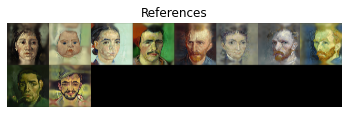

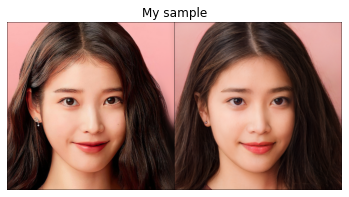

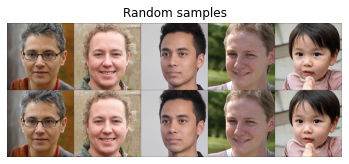

In [ ]:
%matplotlib inline
#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

# display reference images
style_images = []

names = ['arcane_caitlyn.jpeg', 'arcane_jinx.jpeg', 'arcane_jayce.jpeg', 'arcane_viktor.jpeg'] #@param {type:"raw"}

for name in names:
    style_path = f'style_images_aligned/{strip_path_extension(name)}.png'
    style_image = transform(Image.open(style_path))
    style_images.append(style_image)
    
face = transform(aligned_face).to(device).unsqueeze(0)
style_images = torch.stack(style_images, 0).to(device)
display_image(utils.make_grid(style_images, normalize=True, range=(-1, 1)), title='References')

my_output = torch.cat([face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')
plt.show()

output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')
plt.show()